# Simulation for estimating ATE from imputed values

Can we capture the true ATE using estimated labels? Let's do a simulation! Let's try to keep things simple:

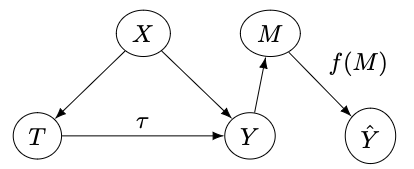

- $X$ is some confounder (e.g. urban/rural where urban areas are wealthier *and* more likely to be treated)
- $T$ is the treatment with a treatment effect $\tau$, (e.g. World Bank intervention)
- $Y$ is the outcome (change in IWI)

In our setting, we usually can't observe IWI directly. Instead, we have to rely on proxy values obtained from EO-ML.

- $M$ is the data we can observe, i.e. the satellite image. In reality, this is most likely influenced by both $X$ and $T$, but we keep it simple.
- $\hat{Y}$ is the estimate of $Y$ that we get by passing our image through the EO-ML model, $f(M)$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from torch import nn, optim
import seaborn as sns
sns.set_theme()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I generate some samples in accordance with the DAG above with $\tau=2.0$

In [2]:
def generate_population(n_samples=10000, tau=2.0, alpha=1.0, sigma_Y=1.0, sigma_M=0.5, seed=42):
    """
    n_samples: Number of samples
    tau: True ATE of treatment T
    alpha: Effect of confounder X on Y
    sigma_Y: Noise in Y
    sigma_M: Noise in M (proxy for Y)
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate confounder X ~ N(0, 1)
    X = np.random.normal(0, 1, n_samples)

    # Generate treatment T ~ Bernoulli(p(X)) where p(X) is a logistic function of X
    p_T_given_X = 1 / (1 + np.exp(-X))  # Logistic function
    T = np.random.binomial(1, p_T_given_X)

    # Generate outcome Y ~ N(tau * T + alpha * X, sigma_Y)
    Y = tau * T + alpha * X + np.random.normal(0, sigma_Y, n_samples)

    # Generate proxy M = Y + noise (M is a noisy version of Y)
    M = Y + np.random.normal(0, sigma_M, n_samples)

    population = pd.DataFrame({
        'X': X,
        'T': T,
        'Y': Y,
        'p_T_given_X': p_T_given_X,
        'M': M
    })

    return population

tau = 2.0
population = generate_population(tau=tau)

I fit a simple linear OLS regressor to estimate $Y$ (wealth level) from our proxy $M$ (image).

In [3]:
def fit_linear_model(population):

    M = population['M'].values.reshape(-1, 1)
    Y = population['Y'].values

    model = LinearRegression()
    model.fit(M, Y)

    pred_Y = model.predict(M)

    res = Y - pred_Y
    population['Y_hat'] = pred_Y
    population['Residuals'] = res
    
    return population

population = fit_linear_model(population)

From these plots, we can see that we do well in terms off MSE. However, looking at the interactions between the residuals and other variables highlights some problems for estimating the ATE.

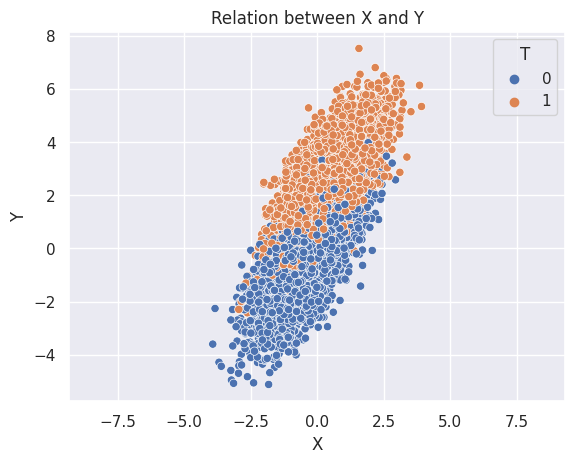

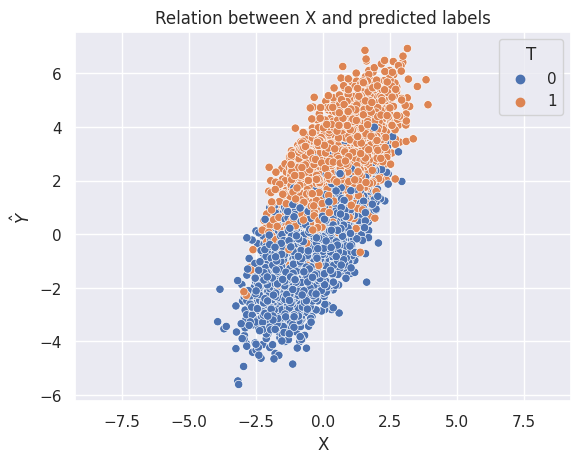

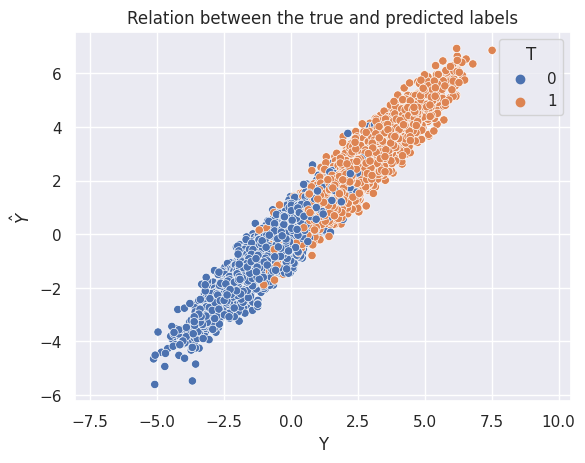

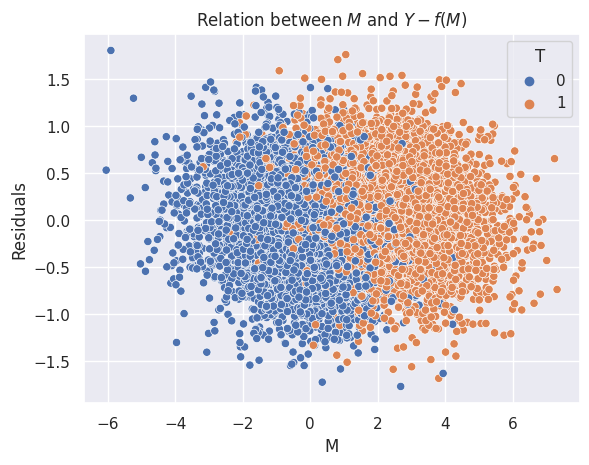

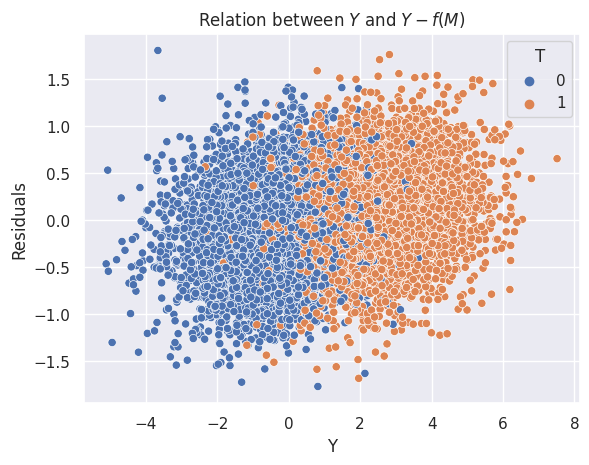

Mean Residual for Treated: -0.093, Mean Residual for Control: 0.093


In [4]:
sns.scatterplot(data=population, x='X', y='Y', hue='T')
plt.title('Relation between X and Y')
plt.axis('equal')
plt.show()

sns.scatterplot(data=population, x='X', y='Y_hat', hue='T')
plt.title('Relation between X and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=population, x='Y', y='Y_hat', hue='T')
plt.title('Relation between the true and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=population, x='M', y='Residuals', hue='T')
plt.title(r'Relation between $M$ and $Y-f(M)$')
plt.show()

sns.scatterplot(data=population, x='Y', y='Residuals', hue='T')
plt.title(r'Relation between $Y$ and $Y-f(M)$')
plt.show()

mean_res_t = population.groupby('T')['Residuals'].mean()
print(f'Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')

Our $\hat{Y}$ ends up overestimating the value when $Y$ is low and underestimating when $Y$ is high. There's a regression-to-the-mean effect, as the overall prediction error is lowest when we smooth out the "noise". As treated samples are more likely to be high and control samples are more likely to be low, this will lead us to underestimate the ATE.

In [5]:
def get_ate(population, pred_Y_col='Y_hat'):

    # Calculate IPTW weights
    weights_treated = population['T'].values / population['p_T_given_X'].values
    weights_control = (1 - population['T'].values) / (1 - population['p_T_given_X'].values)

    # Calculate weighted outcomes
    weighted_outcome_treated = weights_treated * population[pred_Y_col]
    weighted_outcome_control = weights_control * population[pred_Y_col]

    # Estimate the average treatment effect (ATE)
    return np.mean(weighted_outcome_treated - weighted_outcome_control)

ATE_estimate = get_ate(population, pred_Y_col='Y_hat')
print(f'Estimated ATE: {ATE_estimate:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.918, True ATE: 2.000


## Possible fix

What ends up killing the signal is that there is a correlation between the treatment and the residuals. In our setup, we are not allowed to look at the treatment while fitting our model. However, the effect of $T$ on the residuals should go entirely through $Y$, which we do observe. If we can kill this correlation, we shouldn't have this problem. We do this by adding a penalty term for correlation to the MSE-loss and fit a model with SGD:

$$
\operatorname{Loss}= (1 - \lambda) \cdot \operatorname{MSE}(Y, \hat{Y})+\lambda \cdot \operatorname{Corr}(Y, Y-\hat{Y})^2
$$

In [6]:
# Custom loss function
def custom_loss(Y_true, Y_pred, lambda_reg):
    mse_loss = nn.functional.mse_loss(Y_pred, Y_true)
    residuals = Y_true - Y_pred
    # Flatten Y_true and residuals for correlation calculation
    Y_true_flat = Y_true.view(-1)
    residuals_flat = residuals.view(-1)
    corr = torch.corrcoef(torch.stack([Y_true_flat, residuals_flat]))[0, 1]
    return (1.0 - lambda_reg) * mse_loss + lambda_reg * corr**2  # Square correlation to penalize both positive and negative correlation

def fit_decorr_model(population, lambda_reg=0.9, lr=0.01, n_epochs=1000):

    M = population['M'].values.reshape(-1, 1)
    Y = population['Y'].values
    
    M_tensor = torch.tensor(population['M'], dtype=torch.float32).view(-1, 1)  # Match (N, 1) shape
    Y_tensor = torch.tensor(population['Y'], dtype=torch.float32).view(-1, 1)  # Match (N, 1) shape

    decorr_model = nn.Linear(1, 1)  # Simple linear model

    optimizer = optim.SGD(decorr_model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        Y_pred = decorr_model(M_tensor)
        loss = custom_loss(Y_tensor, Y_pred, lambda_reg)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred_Y_decorr = decorr_model(M_tensor)
        pred_Y_decorr = pred_Y_decorr.detach().numpy().flatten()
        population['Y_hat_decorr'] = pred_Y_decorr
        population['Decorrelated Residuals'] = Y - pred_Y_decorr
        
    return population

population = fit_decorr_model(population)

If we pick a high enough value for ```lambda_reg``` we should minimize the correlation between $Y$ and the residuals, at the expense of a lower MSE. This should result in minimizing the correlation between $T$ and the residuals.

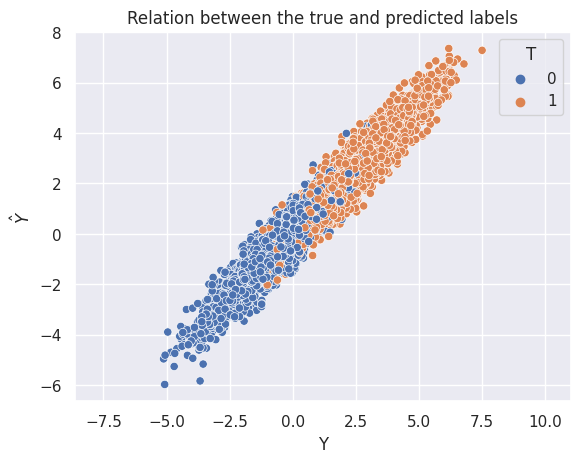

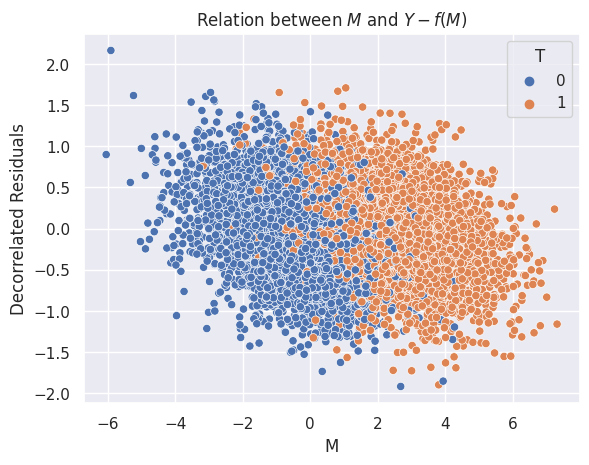

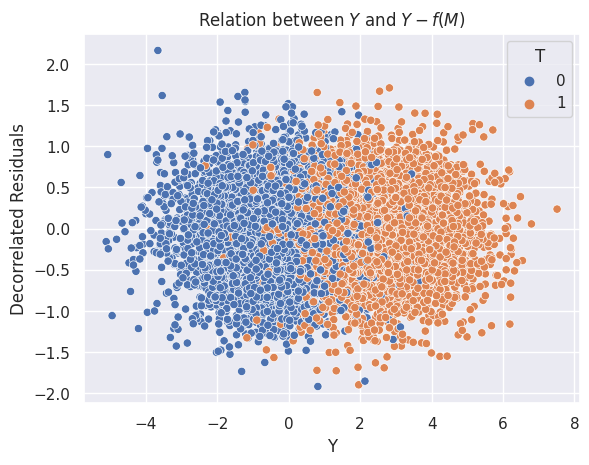

Mean Residual for Treated: -0.055, Mean Residual for Control: -0.038


In [7]:
sns.scatterplot(data=population, x='Y', y='Y_hat_decorr', hue='T')
plt.title('Relation between the true and predicted labels')
plt.ylabel(r'$\hat{Y}$')
plt.axis('equal')
plt.show()

sns.scatterplot(data=population, x='M', y='Decorrelated Residuals', hue='T')
plt.title(r'Relation between $M$ and $Y-f(M)$')
plt.show()

sns.scatterplot(data=population, x='Y', y='Decorrelated Residuals', hue='T')
plt.title(r'Relation between $Y$ and $Y-f(M)$')
plt.show()

mean_res_t = population.groupby('T')['Decorrelated Residuals'].mean()
print(f'Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')

For this "decorrelated" model, the correlation between $Y$ and the resulting residuals is much smaller, same with the correlation to $T$.

In [8]:
print(f"Correlation between Y and OG Residuals {np.corrcoef(population['Y'], population['Residuals'])[0, 1]:.3f}")
print(f"Correlation between Y and Decorrelated Residuals {np.corrcoef(population['Y'], population['Decorrelated Residuals'])[0, 1]:.3f}")
print('')
print(f"Correlation between T and OG Residuals {np.corrcoef(population['T'], population['Residuals'])[0, 1]:.3f}")
print(f"Correlation between T and Decorrelated Residuals {np.corrcoef(population['T'], population['Decorrelated Residuals'])[0, 1]:.3f}")

Correlation between Y and OG Residuals 0.247
Correlation between Y and Decorrelated Residuals 0.008

Correlation between T and OG Residuals 0.191
Correlation between T and Decorrelated Residuals 0.017


We now no longer underestimate the ATE.

In [9]:
# Estimate the average treatment effect (ATE)
ATE_estimate_decorr = get_ate(population, pred_Y_col='Y_hat_decorr')
print(f'Estimated ATE: {ATE_estimate:.3f}, Decorrelated Estimated ATE: {ATE_estimate_decorr:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.918, Decorrelated Estimated ATE: 2.039, True ATE: 2.000


## Correlation Correction

The underestimation of the ATE in our results appears to be a case of regression attenuation, also known as [regression dilution](https://en.wikipedia.org/wiki/Regression_dilution). This phenomenon occurs when we use a noisy proxy, $\hat{Y}$, as an estimate for the true outcome, $Y$. In this scenario, $\hat{Y}$ is a "diluted" version of $Y$, where $\hat{Y}$ includes random noise that reduces the apparent effect size when using $\hat{Y}$ in place of $Y$ in the analysis.

### Disattenuation of Correlation

In 1904, Charles Spearman introduced a correction method known as the [disattenuation of correlation](https://www.jstor.org/stable/1412159?origin=crossref&seq=1) to address regression attenuation. The core idea is to adjust our estimate by the empirical correlation between $\hat{Y}$ and $Y$, which provides a measure of the reliability of $\hat{Y}$ as a proxy for $Y$.

Given that the observed outcome $\hat{Y}$ is related to the true outcome $Y$ with some additive noise:
$$
\hat{Y} = Y + \epsilon,
$$
we can estimate the reliability of $\hat{Y}$ as a proxy by calculating the empirical correlation between $\hat{Y}$ and $Y$. Denote this empirical correlation as $\rho_{\hat{Y},Y}$:
$$
\rho_{\hat{Y},Y} = \frac{\text{Cov}(\hat{Y}, Y)}{\sqrt{\text{Var}(\hat{Y}) \cdot \text{Var}(Y)}}.
$$
This correlation, $\rho_{\hat{Y},Y}$, acts as an attenuation factor. It reflects the degree to which the noise in $\hat{Y}$ dilutes the signal, causing us to underestimate the true ATE.

To correct for this attenuation, we can use $\rho_{\hat{Y},Y}$ as a scaling factor. If $\hat{\tau}$ is the unadjusted ATE estimate derived using $\hat{Y}$, we can adjust it by dividing by $\rho_{\hat{Y},Y}$ to obtain a more accurate estimate:
$$
\tau_{\text{corrected}} = \frac{\hat{\tau}}{\rho_{\hat{Y},Y}}.
$$

This correction should reduce the bias introduced by regression dilution, yielding an ATE estimate that is closer to the true effect size. Note that this approach relies on $\hat{Y}$ being an approximately linear and noisy version of $Y$ with additive noise.

In [13]:
disattenuated_corr = np.cov(population['Y_hat'], population['Y'])[0, 1] / np.sqrt(np.var(population['Y_hat']) * np.var(population['Y']))
ATE_estimate_corrected = ATE_estimate / disattenuated_corr

print(f'Estimated ATE: {ATE_estimate:.3f}, Disattenuation corrected estimated ATE: {ATE_estimate_corrected:.3f}, Decorrelated Estimated ATE: {ATE_estimate_decorr:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.876, Disattenuation corrected estimated ATE: 1.935, Decorrelated Estimated ATE: 1.995, True ATE: 2.000


The disattenuation correction doesn't seem to work. Why not? Have I missunderstood some part of the setup?

## Multiple runs

Let's run a couple of rounds with resampled populations to get confidence intervals

In [14]:
n_boots = 100
tau = 2.0
tau_ests = []
decorr_tau_ests = []
corr_tau_ests = []

for i in range(n_boots):
    
    population = generate_population(tau=tau, seed=i)
    
    # Normal model
    population = fit_linear_model(population)
    ATE_estimate = get_ate(population, pred_Y_col='Y_hat')
    
    # Disattenuation of correlation
    disattenuated_corr = np.cov(population['Y_hat'], population['Y'])[0, 1] / np.sqrt(np.var(population['Y_hat']) * np.var(population['Y']))
    
    population['Y_hat_corr'] = population['Y_hat'] / disattenuated_corr
    ATE_estimate_corrected = get_ate(population, pred_Y_col='Y_hat_corr')
    
    # Decorrelated model
    population = fit_decorr_model(population)
    ATE_estimate_decorr = get_ate(population, pred_Y_col='Y_hat_decorr')
    
    tau_ests.append(ATE_estimate)
    corr_tau_ests.append(ATE_estimate_corrected)
    decorr_tau_ests.append(ATE_estimate_decorr)
    
ATE_estimate = np.mean(tau_ests)
ATE_estimate_decorr = np.mean(decorr_tau_ests)
ATE_estimate_corrected = np.mean(corr_tau_ests)
    
print(f'Estimated ATE: {ATE_estimate:.3f}, Disattenuation corrected estimated ATE: {ATE_estimate_corrected:.3f}, Decorrelated Estimated ATE: {ATE_estimate_decorr:.3f}, True ATE: {tau:.3f}')

Estimated ATE: 1.876, Disattenuation corrected estimated ATE: 1.936, Decorrelated Estimated ATE: 1.995, True ATE: 2.000


When we do this, we see that the OLS model always underestimates the ATE, while the decorrelated one gets it right. Interestingly, the disattenuation corrected one still underestimates the effect.

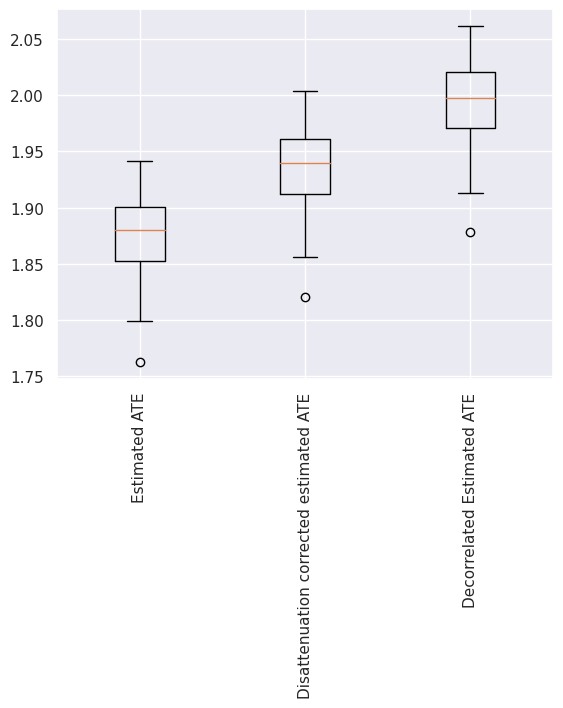

In [12]:
plt.boxplot([tau_ests, corr_tau_ests, decorr_tau_ests], labels=['Estimated ATE', 'Disattenuation corrected estimated ATE', 'Decorrelated Estimated ATE'])
plt.xticks(rotation=90)
plt.show()